In order to figure out who are Person-of-Interest. We'll construct the ML model to find out. 

# EDA

EDA(Exploration Data Analysis) 是做資料分析的第一個階段，主要是為了更了解

In [1018]:
import numpy as np
import pandas as pd
import warnings

In [1019]:
warnings.filterwarnings('ignore')

In [1020]:
pd.options.display.max_columns = 22

In [1021]:
train_data = pd.read_csv('./Datasets/train_data.csv')
test_data = pd.read_csv('./Datasets/test_features.csv')
y_true = train_data['poi']
train_num = len(train_data)
df = pd.concat([train_data.drop('poi', axis = 1), test_data], ignore_index=True, sort = False)

In [1022]:
train_data.shape

(113, 22)

In [1023]:
print(f'Dataset dimension: {df.shape}')
df.head(13)

Dataset dimension: (146, 21)


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
5,HIRKO JOSEPH,NaN,10259.0,NaN,NaN,joe.hirko@enron.com,30766064.0,77978.0,NaN,NaN,NaN,NaN,NaN,2856.0,NaN,NaN,NaN,NaN,NaN,91093.0,30766064.0
6,YEAGER F SCOTT,NaN,NaN,NaN,NaN,scott.yeager@enron.com,8308552.0,53947.0,NaN,NaN,NaN,NaN,NaN,147950.0,3576206.0,NaN,158403.0,NaN,NaN,360300.0,11884758.0
7,COLWELL WESLEY,1200000.0,27610.0,-144062.0,NaN,wes.colwell@enron.com,NaN,16514.0,40.0,240.0,11.0,NaN,NaN,101740.0,698242.0,NaN,288542.0,1132.0,1758.0,1490344.0,698242.0
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,NaN,kenneth.lay@enron.com,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,3600000.0,10359729.0,14761694.0,NaN,1072321.0,2411.0,4273.0,103559793.0,49110078.0
9,GLISAN JR BEN F,600000.0,NaN,NaN,NaN,ben.glisan@enron.com,384728.0,125978.0,16.0,52.0,6.0,NaN,71023.0,200308.0,393818.0,NaN,274975.0,874.0,873.0,1272284.0,778546.0


It is unbiased data. We've got to tackle this problem before constructing the model.

## Feature Engineering

In [1024]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1025]:
# def function to check skewness
from scipy import stats
def check_boxcox(feature_name, lmbda=1, change = False, add_zero_feature= False):
    data = df.loc[df[feature_name] != 0, feature_name]
    plt.show(plt.hist(stats.boxcox(np.abs(data)+1, lmbda = lmbda)))
    if change:
        if add_zero_feature:
            df[feature_name+'_zero'] = (df[feature_name] == 0)
        df[feature_name] = stats.boxcox(np.abs(df[feature_name])+1, lmbda = lmbda)
        print('Update Successfully!')

In [1026]:
def check_outliers(feature_name, clip = None):
    global df
    data = df.loc[df[feature_name] != 0, feature_name]
    print("Data are outliers as it above {}.".format(1.5*(np.quantile(data, 0.75) - np.quantile(data, 0.25))
                                                      +np.quantile(data, 0.75)))
    print("Data are outliers as it below {}.".format(np.quantile(data, 0.25)-
                                                     1.5*(np.quantile(data, 0.75) - np.quantile(data, 0.25))))
    plt.show(plt.boxplot(data))
    if clip is None :
        clip = input('Do you want to clip it?(y/n) ')
    if clip == 'y':
        df[feature_name] = df[feature_name].clip(np.quantile(data, 0.25)-1.5*(np.quantile(data, 0.75) - np.quantile(data, 0.25)),
                                     1.5*(np.quantile(data, 0.75) - np.quantile(data, 0.25)) + np.quantile(data, 0.75))
        df.loc[df[feature_name] != 0, feature_name].plot(kind = 'box')
        print('Update successfully!')

In [1027]:
df.columns

Index(['name', 'bonus', 'deferral_payments', 'deferred_income',
       'director_fees', 'email_address', 'exercised_stock_options', 'expenses',
       'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'restricted_stock',
       'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
       'to_messages', 'total_payments', 'total_stock_value'],
      dtype='object')

### total payment / total stock value

In [1028]:
# Check payment data
x = df[['bonus', 'deferral_payments', 'deferred_income','director_fees', 'expenses','loan_advances', 'long_term_incentive', 'other','salary', 'total_payments']]
x.head()

,bonus,deferral_payments,deferred_income,director_fees,expenses,loan_advances,long_term_incentive,other,salary,total_payments
0,1750000.0,NaN,-3504386.0,NaN,46950.0,NaN,1617011.0,174839.0,420636.0,505050.0
1,5600000.0,NaN,NaN,NaN,29336.0,NaN,1920000.0,22122.0,1111258.0,8682716.0
2,200000.0,NaN,-4167.0,NaN,22884.0,NaN,NaN,1573324.0,211844.0,2003885.0
3,800000.0,NaN,NaN,NaN,118134.0,NaN,602671.0,907502.0,224305.0,2652612.0
4,1250000.0,NaN,-262500.0,NaN,35818.0,NaN,375304.0,486.0,240189.0,1639297.0


In [1029]:
# Compare between total payment by aggregation and total payment from documentation.
x['total_payment_agg'] = df[['bonus', 'deferral_payments', 'deferred_income','director_fees', 'expenses','loan_advances', 'long_term_incentive', 'other','salary']].sum(axis=1)
x['diff_total_payment'] = df['total_payments'] - x['total_payment_agg']
x.loc[(x['diff_total_payment']!=0) & (x['diff_total_payment'].notna())]

,bonus,deferral_payments,deferred_income,director_fees,expenses,loan_advances,long_term_incentive,other,salary,total_payments,total_payment_agg,diff_total_payment
50,NaN,-102500.0,NaN,3285.0,NaN,NaN,NaN,NaN,NaN,102500.0,-99215.0,201715.0
139,NaN,NaN,NaN,137864.0,NaN,NaN,NaN,137864.0,NaN,15456290.0,275728.0,15180562.0


,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value
133,TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,311764000.0,5235198.0,83925000.0,48521928.0,42667589.0,130322299.0,-7576788.0,26704229.0,309886585.0,434509511.0


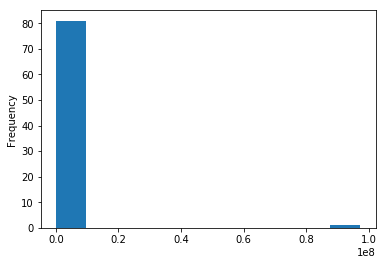

In [1030]:
# Check Outliers
df['bonus'].plot(kind = 'hist')
df.loc[df['bonus']>0.2*(10**8)].dropna(axis = 1)

In [1031]:
# TOTAL Check
total_sum = df.loc[df['name'] != 'TOTAL', ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 
                                           'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 
                                           'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 
                                           'total_stock_value']].sum()
total_doc = df.loc[df['bonus']>0.2*(10**8)].dropna(axis = 1)\
.loc[133, ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses',
           'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary',
           'total_payments', 'total_stock_value']]

total_sum - total_doc

bonus                                  0
deferral_payments                -102500
deferred_income                   102500
director_fees                      38649
exercised_stock_options     -1.28485e+07
expenses                         -141149
loan_advances                          0
long_term_incentive                    0
other                             137864
restricted_stock            -5.25307e+06
restricted_stock_deferred     1.8149e+07
salary                                 0
total_payments               1.54176e+07
total_stock_value           -1.55004e+07
dtype: object

In [1032]:
# Check data (index 50)
df.loc[50]

name                         BELFER ROBERT
bonus                                  NaN
deferral_payments                  -102500
deferred_income                        NaN
director_fees                         3285
email_address                          NaN
exercised_stock_options               3285
expenses                               NaN
from_messages                          NaN
from_poi_to_this_person                NaN
from_this_person_to_poi                NaN
loan_advances                          NaN
long_term_incentive                    NaN
other                                  NaN
restricted_stock                       NaN
restricted_stock_deferred            44093
salary                                 NaN
shared_receipt_with_poi                NaN
to_messages                            NaN
total_payments                      102500
total_stock_value                   -44093
Name: 50, dtype: object

In [1033]:
# Check data (index 139)
df.loc[139]

name                                   BHATNAGAR SANJAY
bonus                                               NaN
deferral_payments                                   NaN
deferred_income                                     NaN
director_fees                                    137864
email_address                sanjay.bhatnagar@enron.com
exercised_stock_options                     2.60449e+06
expenses                                            NaN
from_messages                                        29
from_poi_to_this_person                               0
from_this_person_to_poi                               1
loan_advances                                       NaN
long_term_incentive                                 NaN
other                                            137864
restricted_stock                           -2.60449e+06
restricted_stock_deferred                   1.54563e+07
salary                                              NaN
shared_receipt_with_poi                         

In [1034]:
# Check restricted_stock_deferred
df['restricted_stock_deferred'].describe()

count    1.800000e+01
mean     1.664106e+05
std      4.201494e+06
min     -7.576788e+06
25%     -3.896218e+05
50%     -1.469750e+05
75%     -7.500975e+04
max      1.545629e+07
Name: restricted_stock_deferred, dtype: float64

In [1035]:
## Check positive restricted_stock_deferred
df.loc[df['restricted_stock_deferred']>0]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
50,BELFER ROBERT,NaN,-102500.0,NaN,3285.0,NaN,3285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44093.0,NaN,NaN,NaN,102500.0,-44093.0
139,BHATNAGAR SANJAY,NaN,NaN,NaN,137864.0,sanjay.bhatnagar@enron.com,2604490.0,NaN,29.0,0.0,1.0,NaN,NaN,137864.0,-2604490.0,15456290.0,NaN,463.0,523.0,15456290.0,NaN


In [1036]:
# Check relationship between director_fees and exercised_stock_options
df.loc[(df['director_fees'].notna()) & (df['exercised_stock_options'].notna())]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
41,LEMAISTRE CHARLES,NaN,NaN,-25000.0,112492.0,NaN,412878.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87492.0,412878.0
50,BELFER ROBERT,NaN,-102500.0,NaN,3285.0,NaN,3285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44093.0,NaN,NaN,NaN,102500.0,-44093.0
72,JAEDICKE ROBERT,NaN,NaN,-25000.0,108750.0,NaN,431750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44093.0,-44093.0,NaN,NaN,NaN,83750.0,431750.0
84,DUNCAN JOHN H,NaN,NaN,-25000.0,102492.0,NaN,371750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77492.0,371750.0
133,TOTAL,97343619.0,32083396.0,-27992891.0,1398517.0,NaN,311764000.0,5235198.0,NaN,NaN,NaN,83925000.0,48521928.0,42667589.0,130322299.0,-7576788.0,26704229.0,NaN,NaN,309886585.0,434509511.0
139,BHATNAGAR SANJAY,NaN,NaN,NaN,137864.0,sanjay.bhatnagar@enron.com,2604490.0,NaN,29.0,0.0,1.0,NaN,NaN,137864.0,-2604490.0,15456290.0,NaN,463.0,523.0,15456290.0,NaN


In [1037]:
## Check Stock Values
df.loc[df['total_stock_value'] <0]

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
50,BELFER ROBERT,NaN,-102500.0,NaN,3285.0,NaN,3285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44093.0,NaN,NaN,NaN,102500.0,-44093.0


In [1038]:
df.loc[50]

name                         BELFER ROBERT
bonus                                  NaN
deferral_payments                  -102500
deferred_income                        NaN
director_fees                         3285
email_address                          NaN
exercised_stock_options               3285
expenses                               NaN
from_messages                          NaN
from_poi_to_this_person                NaN
from_this_person_to_poi                NaN
loan_advances                          NaN
long_term_incentive                    NaN
other                                  NaN
restricted_stock                       NaN
restricted_stock_deferred            44093
salary                                 NaN
shared_receipt_with_poi                NaN
to_messages                            NaN
total_payments                      102500
total_stock_value                   -44093
Name: 50, dtype: object

In [1039]:
# Adjust data (index 50)
df.loc[50, 'deferred_income'] = -102500
df.loc[50, 'director_fees'] = 102500
df.loc[50, 'expenses'] = 3285
df.loc[50, 'deferral_payments'] = np.nan
df.loc[50, 'restricted_stock'] = 44093
df.loc[50, 'restricted_stock_deferred'] = -44093
df.loc[50, 'total_stock_value'] = np.nan
df.loc[50, 'exercised_stock_options'] = np.nan
df.loc[50, 'total_payments'] = 3285
df.loc[50]

name                         BELFER ROBERT
bonus                                  NaN
deferral_payments                      NaN
deferred_income                    -102500
director_fees                       102500
email_address                          NaN
exercised_stock_options                NaN
expenses                              3285
from_messages                          NaN
from_poi_to_this_person                NaN
from_this_person_to_poi                NaN
loan_advances                          NaN
long_term_incentive                    NaN
other                                  NaN
restricted_stock                     44093
restricted_stock_deferred           -44093
salary                                 NaN
shared_receipt_with_poi                NaN
to_messages                            NaN
total_payments                        3285
total_stock_value                      NaN
Name: 50, dtype: object

In [1040]:
df.loc[139]

name                                   BHATNAGAR SANJAY
bonus                                               NaN
deferral_payments                                   NaN
deferred_income                                     NaN
director_fees                                    137864
email_address                sanjay.bhatnagar@enron.com
exercised_stock_options                     2.60449e+06
expenses                                            NaN
from_messages                                        29
from_poi_to_this_person                               0
from_this_person_to_poi                               1
loan_advances                                       NaN
long_term_incentive                                 NaN
other                                            137864
restricted_stock                           -2.60449e+06
restricted_stock_deferred                   1.54563e+07
salary                                              NaN
shared_receipt_with_poi                         

In [1041]:
# Adjust data (index 139)
df.loc[139, 'director_fees'] = np.nan
df.loc[139, 'expenses'] = 137864
df.loc[139, 'total_stock_value'] = df.loc[139, 'total_payments']
df.loc[139, 'total_payments'] = df.loc[139, 'expenses']
df.loc[139, 'other'] = np.nan
df.loc[(df['restricted_stock'] < df['restricted_stock_deferred'])].loc[139]
df.loc[139, 'exercised_stock_options'] = df.loc[139, 'restricted_stock_deferred']
df.loc[139, 'restricted_stock_deferred'] = df.loc[139, 'restricted_stock']
df.loc[139, 'restricted_stock'] = np.abs(df.loc[139, 'restricted_stock_deferred'])
df.loc[139]

name                                   BHATNAGAR SANJAY
bonus                                               NaN
deferral_payments                                   NaN
deferred_income                                     NaN
director_fees                                       NaN
email_address                sanjay.bhatnagar@enron.com
exercised_stock_options                     1.54563e+07
expenses                                         137864
from_messages                                        29
from_poi_to_this_person                               0
from_this_person_to_poi                               1
loan_advances                                       NaN
long_term_incentive                                 NaN
other                                               NaN
restricted_stock                            2.60449e+06
restricted_stock_deferred                  -2.60449e+06
salary                                              NaN
shared_receipt_with_poi                         

In [1042]:
# TOTAL Check
total_sum = df.loc[df['name'] != 'TOTAL', ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 
                                           'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 
                                           'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 
                                           'total_stock_value']].sum()
total_doc = df.loc[df['bonus']>0.2*(10**8)].dropna(axis = 1)\
.loc[133, ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses',
           'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary',
           'total_payments', 'total_stock_value']]

total_sum - total_doc

bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
exercised_stock_options      0
expenses                     0
loan_advances                0
long_term_incentive          0
other                        0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
total_payments               0
total_stock_value            0
dtype: object

## Remark pdf highlight

In [1043]:
pdfextramoney = ['BAXTER JOHN C', 'LAY KENNETH L', 'SHELBY REX', 'TILNEY ELIZABETH A', 'URQUHART JOHN A']
pdfInternationalAssignment = ['SHERRIFF JOHN R', 'BANNANTINE JAMES M', 'BERGSIEKER RICHARD P', 'DIMICHELE RICHARD G',
                              'ELLIOTT STEVEN', 'FITZGERALD JAY L', 'FREVERT MARK A', 'GOLD JOSEPH', 'KISHKILL JOSEPH G',
                              'KITCHEN LOUISE']     
pdfConsultant = ['WAKEHAM JOHN', 'URQUHART JOHN A']
df['pdf_FootnotesLaundering'] = df['name'].isin(pdfextramoney)
df['pdf_International_Assignment'] = df['name'].isin(pdfInternationalAssignment)
df['pdf_Consultant'] = df['name'].isin(pdfConsultant)
df = df.loc[df['name'] != 'THE TRAVEL AGENCY IN THE PARK']

In [1044]:
# Splitting TOTAL data
total = df.loc[df['name'] == 'TOTAL']
df = df.loc[df['name'] != 'TOTAL']

### Email data

In [1045]:
# Check email data
x = df.loc[[x for x in df.index if x < train_num], 
           ['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 
            'to_messages']]
x['poi']= y_true.loc[df.index].replace({True:'poi', False:'unpoi'})

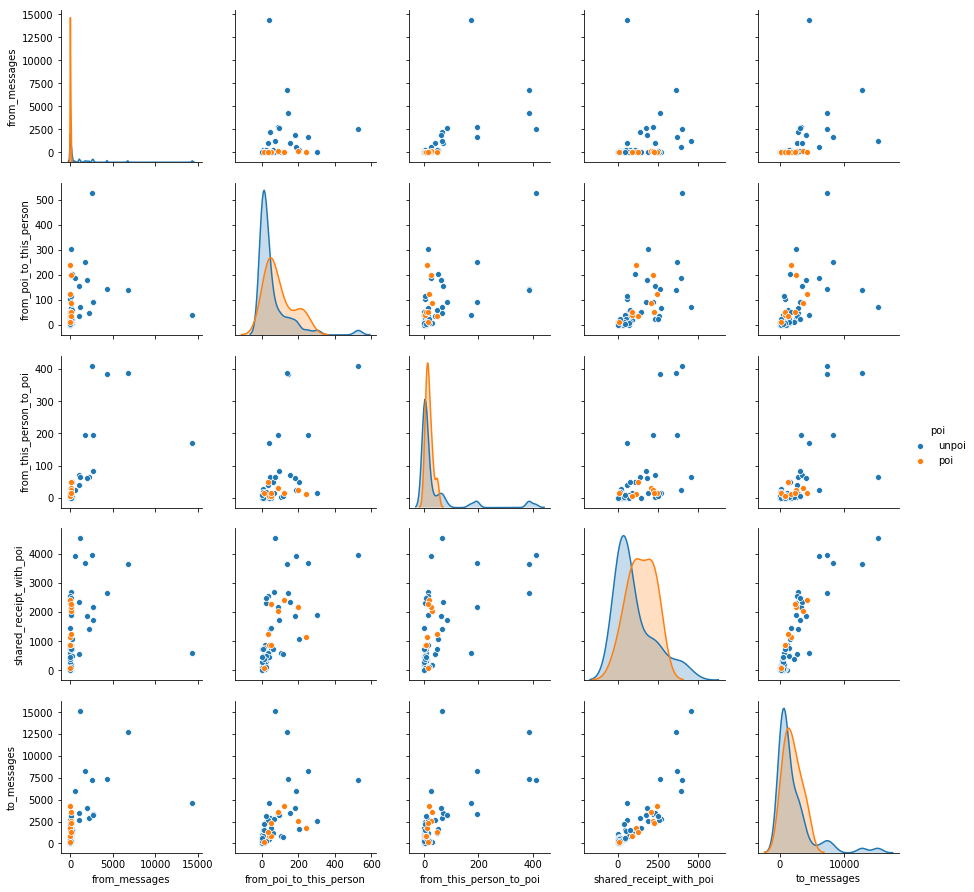

In [1046]:
g = sns.pairplot(x, hue = 'poi', hue_order=['unpoi', 'poi'])

In [1047]:
# label group of from_messages
x.loc[x['poi']=='poi', 'from_messages'].describe()

count      9.000000
mean      60.444444
std       43.243818
min       16.000000
25%       36.000000
50%       40.000000
75%       82.000000
max      144.000000
Name: from_messages, dtype: float64

In [1048]:
# mark specific target
df['from_messages_group'] = df['from_messages'] < 150

In [1049]:
# check outliers of from_messages
df.loc[df['from_messages']>10000, 'from_messages'] = df['from_messages'].median()

In [1050]:
# label outliers of from_poi_to_this_person
df.loc[df['from_poi_to_this_person'] > 400, ['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 
            'to_messages']]

,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages
33,2585.0,528.0,411.0,3962.0,7259.0


In [1051]:
# Remark who didn't have email
df['email_exist'] = df['email_address'].notna()
df.drop('email_address', axis = 1, inplace=True)

In [1052]:
# Fill NA's for email data with 0
from collections import defaultdict
d = defaultdict(lambda: 0)
for v in ['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']:
    d[v]
df.fillna(value=d, inplace=True)

## Payment data

In [1053]:
# Fill NA's for payment data with 0
from collections import defaultdict
d = defaultdict(lambda: 0)
for v in ['bonus', 'deferral_payments', 'deferred_income','director_fees', 'expenses','loan_advances','long_term_incentive', 'other','salary', 'total_payments']:
    d[v]
df.fillna(value=d, inplace=True)

In [1054]:
# Fill NA's for Stock data with 0
from collections import defaultdict
d = defaultdict(lambda: 0)
for v in ['exercised_stock_options','restricted_stock', 'restricted_stock_deferred','total_stock_value']:
    d[v]
df.fillna(value=d, inplace=True)

In [1055]:
# Check email data
x = df.loc[[x for x in df.index if x < train_num], 
           ['bonus', 'deferral_payments', 'deferred_income','director_fees', 'expenses','loan_advances','long_term_incentive', 'other','salary']]
x['poi']= y_true.loc[df.index].replace({True:'poi', False:'unpoi'})

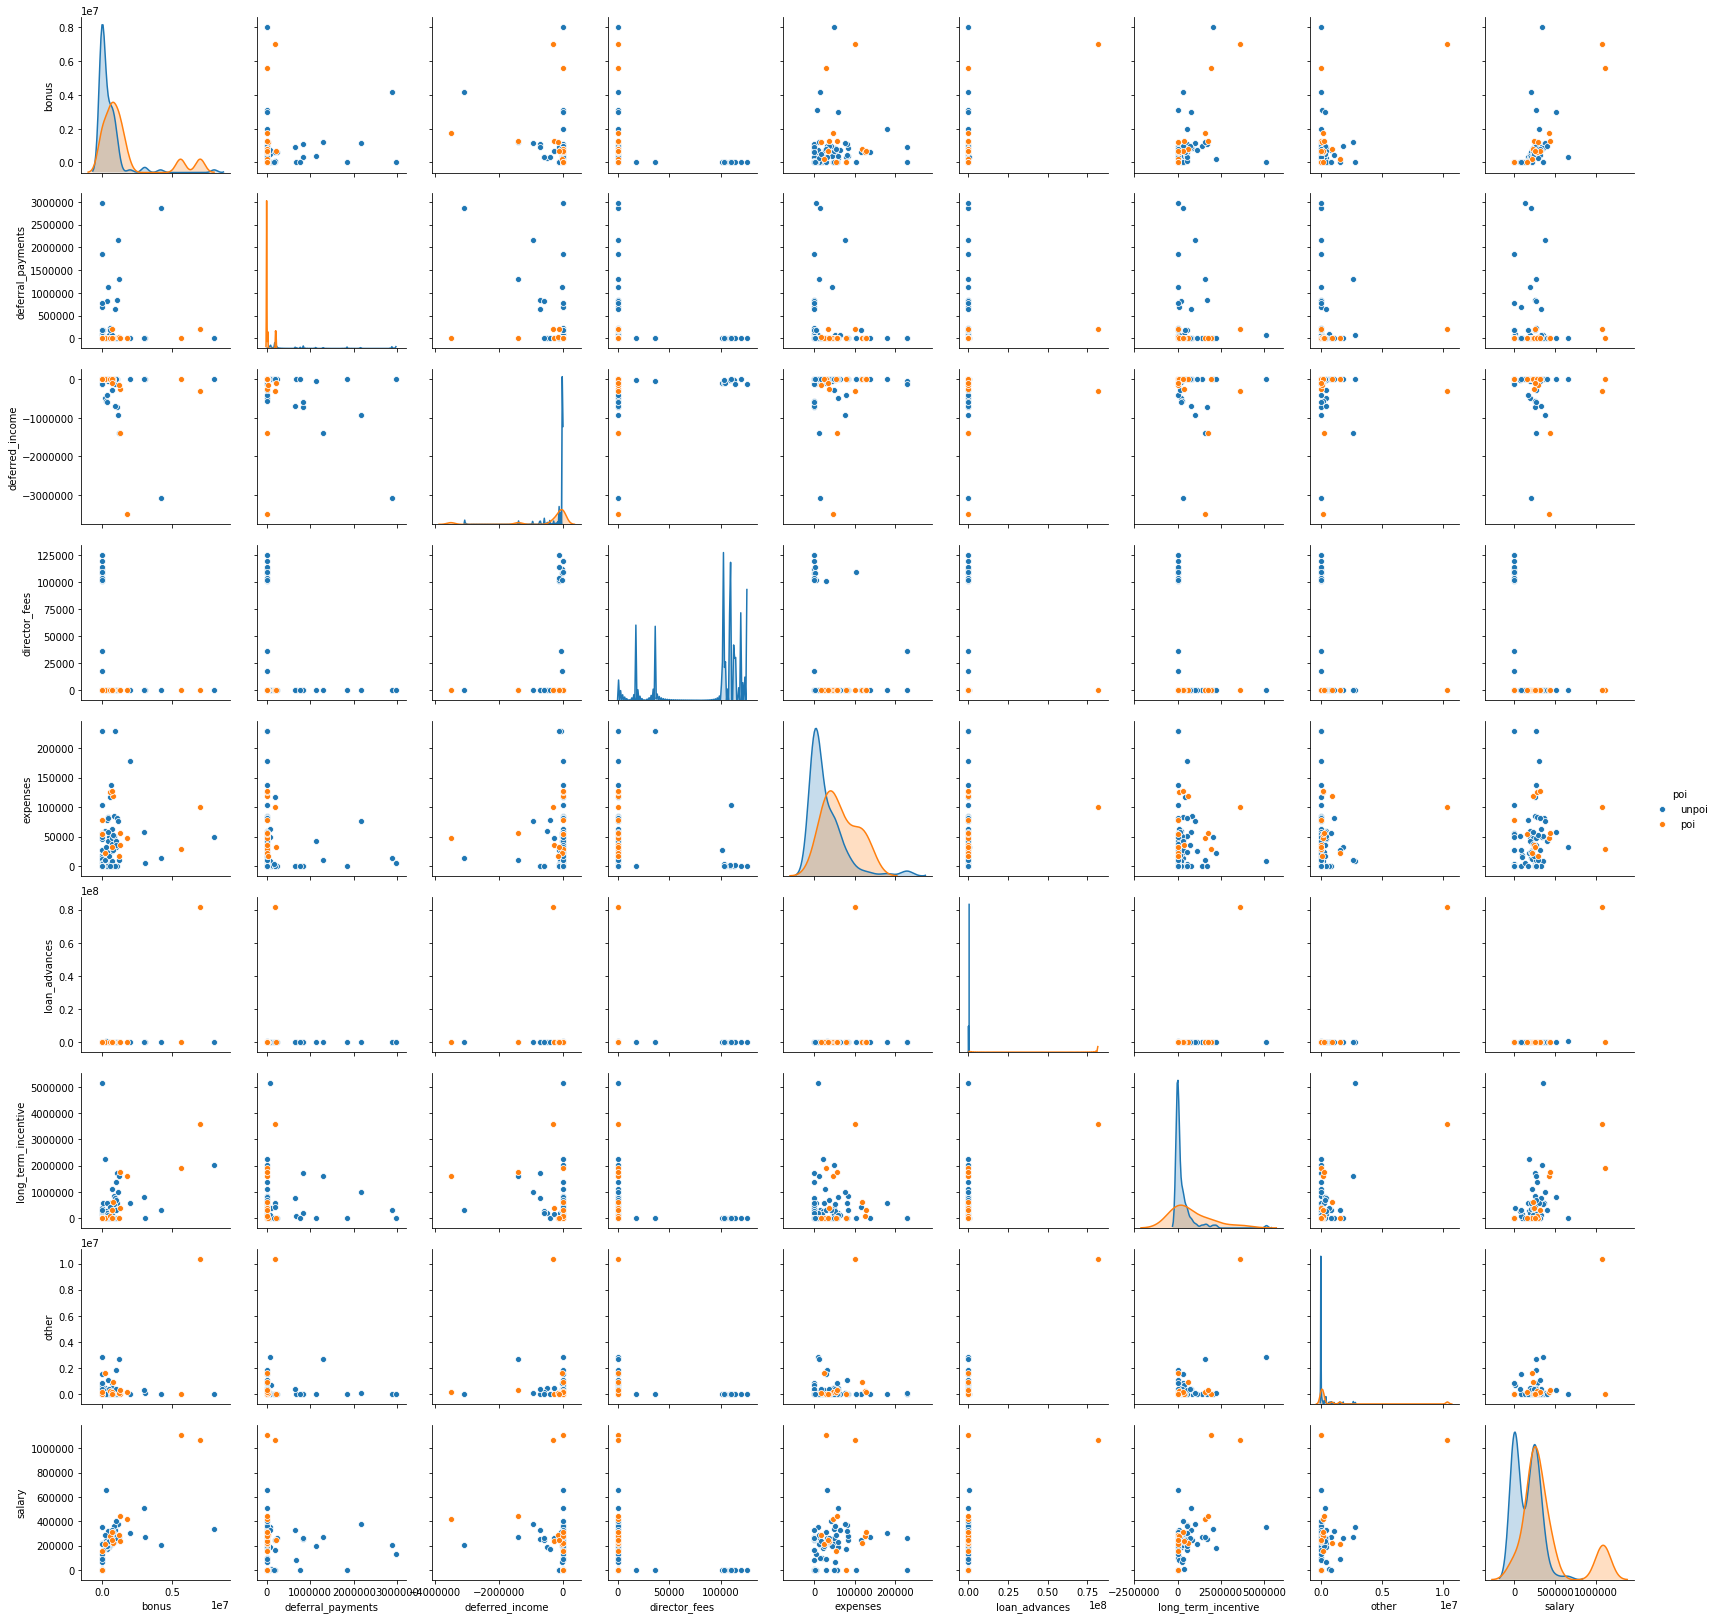

In [1056]:
g = sns.pairplot(x, hue = 'poi', hue_order=['unpoi', 'poi'])

In [1057]:
x.loc[x['poi'] == 'poi', 'deferral_payments'].describe()

count        13.000000
mean      35035.230769
std       77551.058799
min           0.000000
25%           0.000000
50%           0.000000
75%       10259.000000
max      214678.000000
Name: deferral_payments, dtype: float64

In [1058]:
# mark poi tendency
df['bonus_group'] = (df['bonus']<0.25) | (df['bonus']>0.5)

In [1059]:
# mark deferal_payments
df['deferral_payments_group'] = df['deferral_payments'] < 250000

In [1060]:
# ouliers of deferred_income
x.loc[x['deferred_income'] <-2000000, ['bonus', 'deferral_payments', 'deferred_income','director_fees', 'expenses','loan_advances','long_term_incentive', 'other','salary']]

,bonus,deferral_payments,deferred_income,director_fees,expenses,loan_advances,long_term_incentive,other,salary
0,1750000.0,0.0,-3504386.0,0.0,46950.0,0.0,1617011.0,174839.0,420636.0
14,4175000.0,2869717.0,-3081055.0,0.0,13868.0,0.0,304805.0,152.0,201955.0


In [1061]:
# clip deferred_income
df.loc[df['deferred_income']< -2000000,'deferred_income'] = df.loc[df['deferred_income']> -2000000,'deferred_income'].min()

In [1062]:
# Remark non-employee
df['non-employee'] = df['director_fees'] >0
# df = df.loc[df['director_fees'] ==0]

In [1063]:
# loan
df.loc[df['loan_advances'] == df['loan_advances'].max()]

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,...,to_messages,total_payments,total_stock_value,pdf_FootnotesLaundering,pdf_International_Assignment,pdf_Consultant,from_messages_group,email_exist,bonus_group,deferral_payments_group,non-employee
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,0.0,34348384.0,99832.0,36.0,123.0,16.0,81525000.0,...,4273.0,103559793.0,49110078.0,True,False,False,True,True,True,True,False


In [1064]:
x.loc[(df['loan_advances'] <81525000.0) & (df['loan_advances']>0), 'loan_advances']

110    400000.0
Name: loan_advances, dtype: float64

In [1065]:
# drop loan feature
df.drop('loan_advances', axis = 1, inplace=True)

In [1066]:
# outlier of other
df.loc[df['other'] == df['other'].max()]

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,...,to_messages,total_payments,total_stock_value,pdf_FootnotesLaundering,pdf_International_Assignment,pdf_Consultant,from_messages_group,email_exist,bonus_group,deferral_payments_group,non-employee
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,0.0,34348384.0,99832.0,36.0,123.0,16.0,3600000.0,...,4273.0,103559793.0,49110078.0,True,False,False,True,True,True,True,False


In [1067]:
df.loc[df['salary'] > 1000000, ['name','bonus', 'deferral_payments', 'deferred_income','director_fees', 'expenses','loan_advances','long_term_incentive', 'other','salary']]

,name,bonus,deferral_payments,deferred_income,director_fees,expenses,loan_advances,long_term_incentive,other,salary
1,SKILLING JEFFREY K,5600000.0,0.0,0.0,0.0,29336.0,NaN,1920000.0,22122.0,1111258.0
8,LAY KENNETH L,7000000.0,202911.0,-300000.0,0.0,99832.0,NaN,3600000.0,10359729.0,1072321.0
119,FREVERT MARK A,2000000.0,6426990.0,-1386055.0,0.0,86987.0,NaN,1617011.0,7427621.0,1060932.0


In [1068]:
# mark/drop high income
df['high_income'] = df['salary'] > 1000000
# df = df.loc[df['name'] != 'LAY KENNETH L']

### Stock data

In [1069]:
# Check email data
x = df.loc[[x for x in df.index if x < train_num], 
           ['exercised_stock_options','restricted_stock', 'restricted_stock_deferred','total_stock_value']]
x['poi']= y_true.loc[df.index].replace({True:'poi', False:'unpoi'})

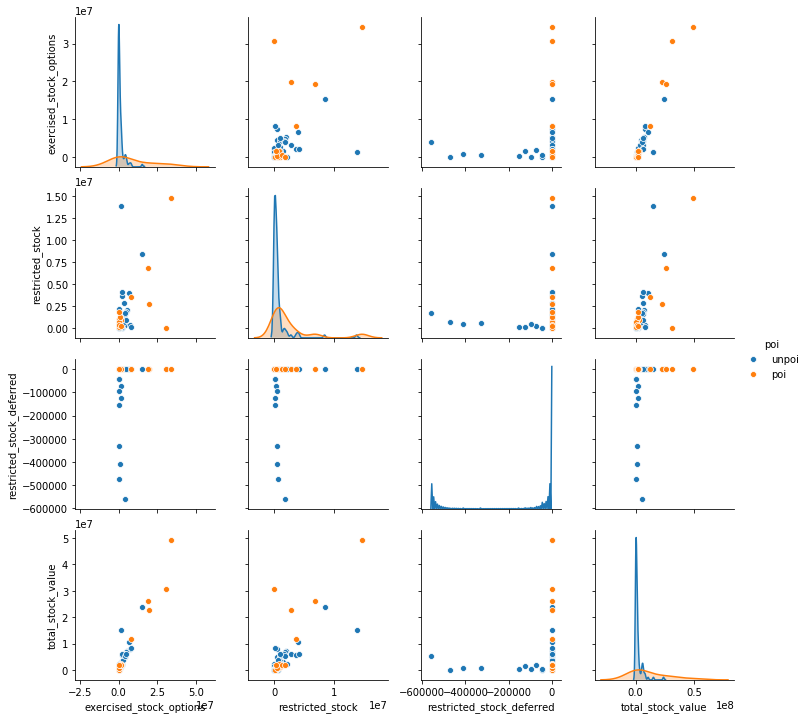

In [1070]:
g = sns.pairplot(x, hue = 'poi', hue_order=['unpoi', 'poi'])

In [1071]:
# profile of restricted_stock_deferred
x.loc[x['poi'] == 'poi', 'restricted_stock_deferred']

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
Name: restricted_stock_deferred, dtype: float64

In [1072]:
# drop restricted_stock_deferred
df['restricted_stock_deferred_group'] = df['restricted_stock_deferred'] == 0
df.drop('restricted_stock_deferred', axis =1, inplace=True)

## User Features

In [1073]:
df['ratio_irreguarRegular_income'] = (df['bonus'] + df['deferral_payments'] + df['expenses'] + df['long_term_incentive'] + 
                                     df['other'])

In [1074]:
df['ratio_irreguarRegular_income'].fillna(0, inplace = True)
# check_outliers('ratio_irreguarRegular_income', 'y')

In [1075]:
# Remark to_messages error
df['messages_send_error'] = (df['from_this_person_to_poi'] + df['shared_receipt_with_poi'] > df['to_messages'])

In [1076]:
# Remark from_messages error
df['messages_receive_error'] = (df['from_poi_to_this_person'] > df['from_messages'])

In [1077]:
# Proportion over sending messages to poi
df['prop_send_poi'] = ((df['from_this_person_to_poi'] + df['shared_receipt_with_poi']) / df['to_messages'])
df.loc[df['prop_send_poi'].isna(), 'prop_send_poi'] = 0

In [1078]:
# Proportion over recieving messages to poi
df['prop_receive_poi'] = (df['from_poi_to_this_person'] / df['from_messages'])
df.loc[df['prop_receive_poi'].isna(), 'prop_receive_poi'] = 0

In [1079]:
df[['from_this_person_to_poi_prop', 'from_poi_to_this_person_prop','shared_receipt_with_poi_prop', 'to_messages_prop', 
    'from_messages_prop']] = \
df[['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi', 'to_messages', 'from_messages']]\
.div(df[['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi', 'to_messages', 'from_messages']]\
     .sum(axis =0))

In [1080]:
df['cover_up_gold'] = ((df['expenses'] + df['other'] +df['salary'])*df['prop_send_poi']).sum()*df['prop_receive_poi']

In [1081]:
# Remark holders
df['holders'] = (df['salary'] == 0) & ~df['non-employee'] & (df['total_stock_value'] > 0)
# df['holders'] = (df['salary'] == 0) & (df['total_stock_value'] > 0)

In [1082]:
# Load Sex Info
sexInfo = pd.read_csv('name_sex.csv')
sexInfo.head()

,name,sex
0,RICE KENNETH D,M
1,SKILLING JEFFREY K,M
2,SHELBY REX,M
3,KOPPER MICHAEL J,M
4,CALGER CHRISTOPHER F,M


In [1083]:
# combine sex data
df = df.reset_index().merge(sexInfo, how='left').set_index('index')

In [1084]:
# Check email data
x = df.loc[[x for x in df.index if x < train_num], 
           ['ratio_irreguarRegular_income', 'from_this_person_to_poi_prop', 'from_poi_to_this_person_prop',
            'shared_receipt_with_poi_prop', 'to_messages_prop','from_messages_prop', 'cover_up_gold']]
x['poi']= y_true.loc[df.index].replace({True:'poi', False:'unpoi'})

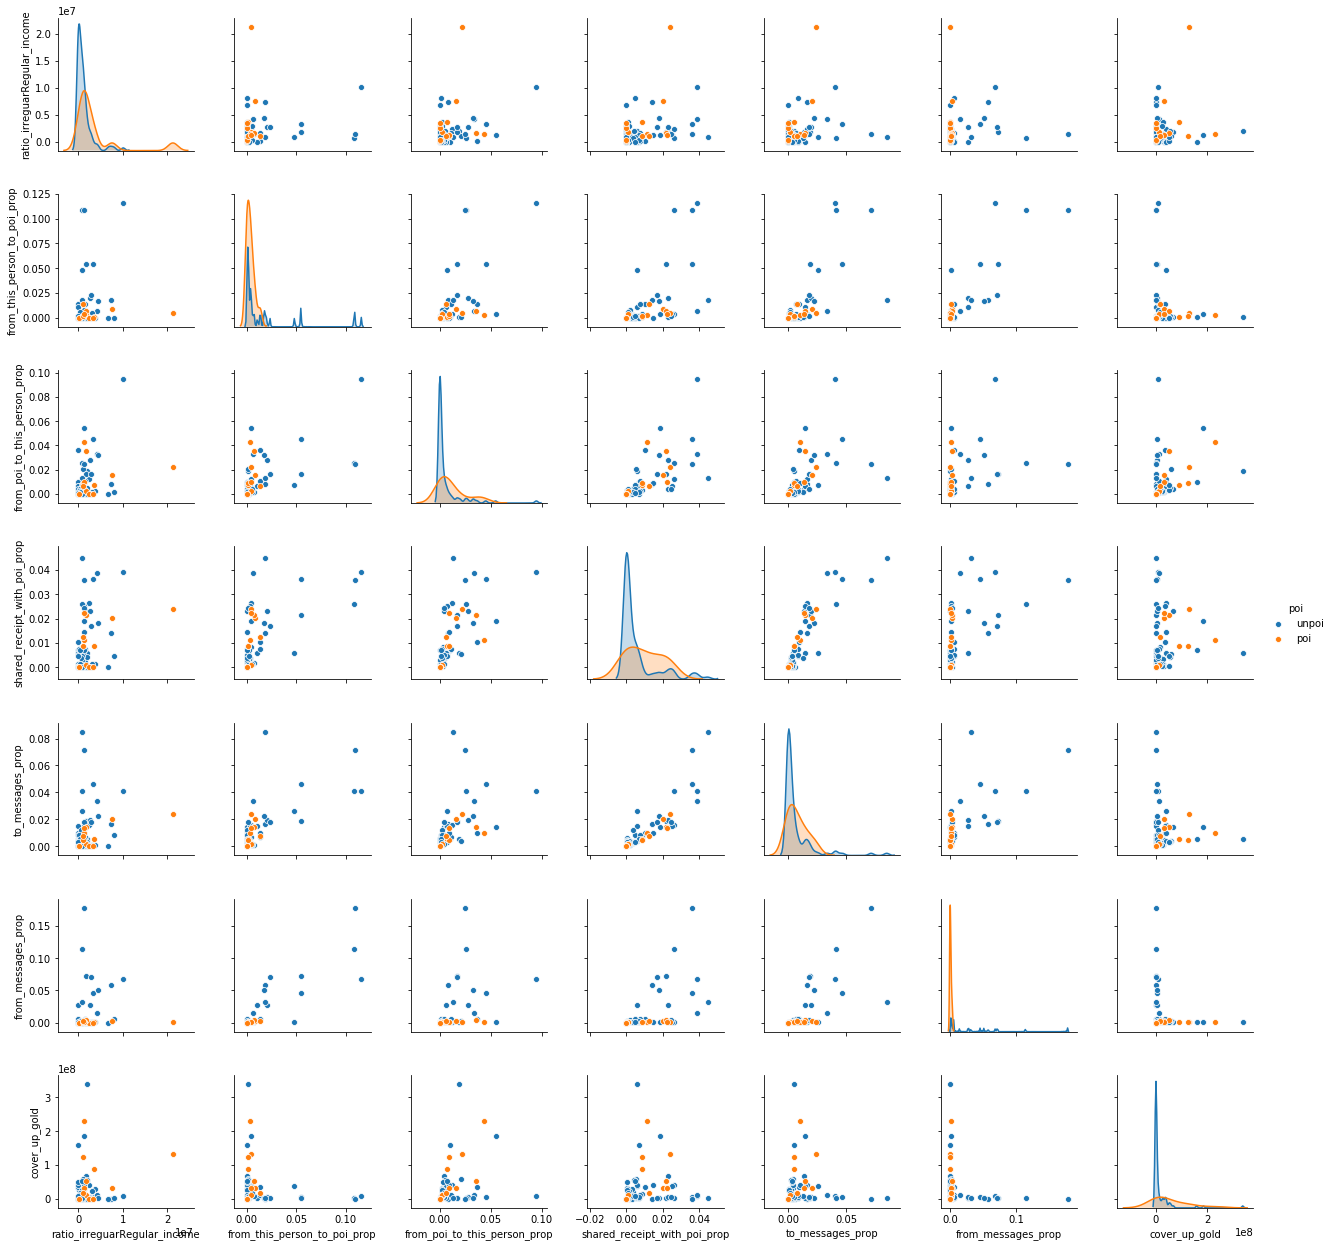

In [1085]:
g = sns.pairplot(x, hue = 'poi', hue_order=['unpoi', 'poi'])

## Scaler

In [1086]:
numeric = []
for col, ty in zip(df.columns, df.dtypes):
    if ty == float:
        numeric.append(col)
print(f'Numeric features: {numeric}')

Numeric features: ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value', 'ratio_irreguarRegular_income', 'prop_send_poi', 'prop_receive_poi', 'from_this_person_to_poi_prop', 'from_poi_to_this_person_prop', 'shared_receipt_with_poi_prop', 'to_messages_prop', 'from_messages_prop', 'cover_up_gold']


In [1087]:
from sklearn.preprocessing import MaxAbsScaler
enc = MaxAbsScaler()
for col in numeric:
    df.loc[:train_num, col] = enc.fit_transform(df.loc[:train_num, col].values.reshape(-1,1))
    df.loc[train_num:, col] = enc.transform(df.loc[train_num:, col].values.reshape(-1,1))

In [1088]:
df.replace({True:1, False:0}, inplace = True)

## Drop Sample

In [1092]:
pd.options.display.max_rows = 500

In [1093]:
df

,name,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,pdf_FootnotesLaundering,pdf_International_Assignment,pdf_Consultant,from_messages_group,email_exist,bonus_group,deferral_payments_group,non-employee,high_income,restricted_stock_deferred_group,ratio_irreguarRegular_income,messages_send_error,messages_receive_error,prop_send_poi,prop_receive_poi,from_this_person_to_poi_prop,from_poi_to_this_person_prop,shared_receipt_with_poi_prop,to_messages_prop,from_messages_prop,cover_up_gold,holders,sex
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,RICE KENNETH D,2.187500e-01,0.000000e+00,-1.000000e+00,0.000000,5.762767e-01,2.052342e-01,0.002663,0.079545,0.009732,0.314261,1.687679e-02,1.861822e-01,3.785224e-01,0.156493,0.059740,4.876893e-03,4.590206e-01,0,0,0,1,1,1,1,0,0,1,1.687856e-01,0,1,0.902697,0.264151,0.009732,0.079545,0.156493,0.059740,0.002663,2.641509e-01,0,M
1,SKILLING JEFFREY K,7.000000e-01,0.000000e+00,0.000000e+00,0.000000,5.604339e-01,1.282375e-01,0.015979,0.166667,0.072993,0.373146,2.135384e-03,4.636102e-01,1.000000e+00,0.369861,0.239422,8.384254e-02,5.313303e-01,0,0,0,1,1,1,1,0,1,1,3.560949e-01,0,0,0.537667,0.092243,0.072993,0.166667,0.369861,0.239422,0.015979,9.224319e-02,0,M
2,SHELBY REX,2.500000e-02,0.000000e+00,-3.006374e-03,0.000000,4.729177e-02,1.000337e-01,0.005770,0.024621,0.034063,0.000000,1.518692e-01,5.888349e-02,1.906344e-01,0.016483,0.014852,1.935003e-02,5.077605e-02,1,0,0,1,1,1,1,0,0,1,8.447785e-02,0,0,0.439216,0.037736,0.034063,0.024621,0.016483,0.014852,0.005770,3.773585e-02,0,M
3,KOPPER MICHAEL J,1.000000e-01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.164034e-01,0.000000,0.000000,0.000000,0.117127,8.759901e-02,6.672893e-02,2.018478e-01,0.000000,0.000000,2.561430e-02,2.005763e-02,0,0,0,0,1,1,1,0,0,1,1.142062e-01,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,M
4,CALGER CHRISTOPHER F,1.562500e-01,0.000000e+00,-1.893864e-01,0.000000,0.000000e+00,1.565725e-01,0.021305,0.376894,0.060827,0.072939,4.691242e-05,8.537435e-03,2.161415e-01,0.396305,0.171496,1.582947e-02,2.566215e-03,0,0,0,1,1,1,1,0,0,1,7.814745e-02,0,1,0.801703,0.156447,0.060827,0.376894,0.396305,0.171496,0.021305,1.564465e-01,0,M
5,HIRKO JOSEPH,0.000000e+00,3.460610e-03,0.000000e+00,0.000000,8.957063e-01,3.408681e-01,0.000000,0.000000,0.000000,0.000000,2.756829e-04,0.000000e+00,0.000000e+00,0.000000,0.000000,8.796174e-04,6.264715e-01,0,0,0,0,1,1,1,0,0,1,4.284215e-03,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1,M
6,YEAGER F SCOTT,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.418906e-01,2.358205e-01,0.000000,0.000000,0.000000,0.000000,1.428126e-02,2.422626e-01,1.425439e-01,0.000000,0.000000,3.479149e-03,2.420024e-01,0,0,0,0,1,1,1,0,0,1,9.495462e-03,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,M
7,COLWELL WESLEY,1.500000e-01,9.313525e-03,-1.039367e-01,0.000000,0.000000e+00,7.218825e-02,0.005918,0.454545,0.026764,0.000000,9.820720e-03,4.730094e-02,2.596535e-01,0.205035,0.116047,1.439115e-02,1.421790e-02,0,0,0,1,1,1,1,0,0,1,6.329763e-02,0,1,0.611925,0.679245,0.026764,0.454545,0.205035,0.116047,0.005918,6.792453e-01,0,M
8,LAY KENNETH L,8.750000e-01,6.844682e-02,-2.164416e-01,0.000000,1.000000e+00,4.363992e-01,0.005326,0.232955,0.038929,0.699649,1.000000e+00,1.000000e+00,9.649613e-01,0.436696,0.282065,1.000000e+00,1.000000e+00,1,0,0,1,1,1,1,0,1,1,1.000000e+00,0,1,0.534574,0.386792,0.038929,0.232955,0.436696,0.282065,0.005326,3.867925e-01,0,M


df = df.loc[df['director_fees'] == df['director_fees'].min()]
df = df.loc[df['sex'] != 'c']
df.drop(['director_fees'], axis = 1, inplace = True)

In [1094]:
name = df['name']
df.drop('name', axis = 1, inplace=True)
df = pd.get_dummies(df, drop_first=True)

In [1095]:
df

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,pdf_FootnotesLaundering,pdf_International_Assignment,pdf_Consultant,from_messages_group,email_exist,bonus_group,deferral_payments_group,non-employee,high_income,restricted_stock_deferred_group,ratio_irreguarRegular_income,messages_send_error,messages_receive_error,prop_send_poi,prop_receive_poi,from_this_person_to_poi_prop,from_poi_to_this_person_prop,shared_receipt_with_poi_prop,to_messages_prop,from_messages_prop,cover_up_gold,holders,sex_M
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.187500e-01,0.000000e+00,-1.000000e+00,0.000000,5.762767e-01,2.052342e-01,0.002663,0.079545,0.009732,0.314261,1.687679e-02,1.861822e-01,3.785224e-01,0.156493,0.059740,4.876893e-03,4.590206e-01,0,0,0,1,1,1,1,0,0,1,1.687856e-01,0,1,0.902697,0.264151,0.009732,0.079545,0.156493,0.059740,0.002663,2.641509e-01,0,1
1,7.000000e-01,0.000000e+00,0.000000e+00,0.000000,5.604339e-01,1.282375e-01,0.015979,0.166667,0.072993,0.373146,2.135384e-03,4.636102e-01,1.000000e+00,0.369861,0.239422,8.384254e-02,5.313303e-01,0,0,0,1,1,1,1,0,1,1,3.560949e-01,0,0,0.537667,0.092243,0.072993,0.166667,0.369861,0.239422,0.015979,9.224319e-02,0,1
2,2.500000e-02,0.000000e+00,-3.006374e-03,0.000000,4.729177e-02,1.000337e-01,0.005770,0.024621,0.034063,0.000000,1.518692e-01,5.888349e-02,1.906344e-01,0.016483,0.014852,1.935003e-02,5.077605e-02,1,0,0,1,1,1,1,0,0,1,8.447785e-02,0,0,0.439216,0.037736,0.034063,0.024621,0.016483,0.014852,0.005770,3.773585e-02,0,1
3,1.000000e-01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.164034e-01,0.000000,0.000000,0.000000,0.117127,8.759901e-02,6.672893e-02,2.018478e-01,0.000000,0.000000,2.561430e-02,2.005763e-02,0,0,0,0,1,1,1,0,0,1,1.142062e-01,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,1
4,1.562500e-01,0.000000e+00,-1.893864e-01,0.000000,0.000000e+00,1.565725e-01,0.021305,0.376894,0.060827,0.072939,4.691242e-05,8.537435e-03,2.161415e-01,0.396305,0.171496,1.582947e-02,2.566215e-03,0,0,0,1,1,1,1,0,0,1,7.814745e-02,0,1,0.801703,0.156447,0.060827,0.376894,0.396305,0.171496,0.021305,1.564465e-01,0,1
5,0.000000e+00,3.460610e-03,0.000000e+00,0.000000,8.957063e-01,3.408681e-01,0.000000,0.000000,0.000000,0.000000,2.756829e-04,0.000000e+00,0.000000e+00,0.000000,0.000000,8.796174e-04,6.264715e-01,0,0,0,0,1,1,1,0,0,1,4.284215e-03,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1,1
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.418906e-01,2.358205e-01,0.000000,0.000000,0.000000,0.000000,1.428126e-02,2.422626e-01,1.425439e-01,0.000000,0.000000,3.479149e-03,2.420024e-01,0,0,0,0,1,1,1,0,0,1,9.495462e-03,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,1
7,1.500000e-01,9.313525e-03,-1.039367e-01,0.000000,0.000000e+00,7.218825e-02,0.005918,0.454545,0.026764,0.000000,9.820720e-03,4.730094e-02,2.596535e-01,0.205035,0.116047,1.439115e-02,1.421790e-02,0,0,0,1,1,1,1,0,0,1,6.329763e-02,0,1,0.611925,0.679245,0.026764,0.454545,0.205035,0.116047,0.005918,6.792453e-01,0,1
8,8.750000e-01,6.844682e-02,-2.164416e-01,0.000000,1.000000e+00,4.363992e-01,0.005326,0.232955,0.038929,0.699649,1.000000e+00,1.000000e+00,9.649613e-01,0.436696,0.282065,1.000000e+00,1.000000e+00,1,0,0,1,1,1,1,0,1,1,1.000000e+00,0,1,0.534574,0.386792,0.038929,0.232955,0.436696,0.282065,0.005326,3.867925e-01,0,1


# ML model

In [1096]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [1103]:
# drop features
dropout = ['pdf_Consultant', 'from_messages_group', 'from_messages_prop', 'email_exist', 'pdf_FootnotesLaundering',
          'pdf_International_Assignment', 'sex_M', 'total_stock_value', 'total_payments', 'bonus_group', 'to_messages',
          'bonus', 'deferral_payments_group', 'non-employee', 'from_this_person_to_poi_prop', 'high_income', 'cover_up_gold',
          'holders', 'long_term_incentive', 'deferral_payments', 'from_poi_to_this_person_prop', 
        'restricted_stock_deferred_group', 'to_messages_prop', 'from_messages', 'director_fees']
print(dropout)
df_dropout = df.drop(dropout, axis = 1)
# , 'loan_advances', 'total_payments', 'non-employee'

['pdf_Consultant', 'from_messages_group', 'from_messages_prop', 'email_exist', 'pdf_FootnotesLaundering', 'pdf_International_Assignment', 'sex_M', 'total_stock_value', 'total_payments', 'bonus_group', 'to_messages', 'bonus', 'deferral_payments_group', 'non-employee', 'from_this_person_to_poi_prop', 'high_income', 'cover_up_gold', 'holders', 'long_term_incentive', 'deferral_payments', 'from_poi_to_this_person_prop', 'restricted_stock_deferred_group', 'to_messages_prop', 'from_messages', 'director_fees']


## Imbalanced Data

In [1104]:
X_train = df_dropout.loc[[x for x in df.index if x < train_num]].as_matrix()
X_test = df_dropout.loc[[x for x in df.index if x >= train_num]].as_matrix()
y_train = y_true.loc[[x for x in df.index if x < train_num]].as_matrix()

X_train_0, X_val_0, y_train_0, y_val_0 = train_test_split(X_train[~y_train],
                                                            y_train[~y_train],
                                                            test_size = 0.4, random_state = 168)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train[y_train],
                                                            y_train[y_train],
                                                            test_size = 0.4, random_state = 168)
X_train = np.concatenate([X_train_0, X_train_1])
X_val = np.concatenate([X_val_0, X_val_1])
y_train = np.concatenate([y_train_0, y_train_1])
y_val = np.concatenate([y_val_0, y_val_1])

# X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 168)
# X_train_csr = csr_matrix(X_train)
# X_val_csr = csr_matrix(X_val)
# X_test_csr = csr_matrix(X_test)

In [1114]:
y_true.loc[[x for x in df.index if x < train_num]].as_matrix()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [1105]:
X_train.shape

(66, 15)

In [1106]:
from imblearn.over_sampling import ADASYN
smote_enn = ADASYN(random_state=1)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

In [1107]:
X_train.shape

(118, 15)

In [1108]:
print(f'True: {y_train.sum()}')
print(f'False: {y_train.size - y_train.sum()}')

True: 59
False: 59


In [1109]:
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = X_val, label = y_val)

## Light Gradient Boosting

In [1110]:
import lightgbm as lgb

In [1111]:
# gs.best_params_

In [1112]:
params = {'boosting': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'is_training_metric': True, 
          'random_state': 42, 'class_weight': 'balanced',
          'num_leaves':2,
          'min_data_in_leaf':7}
#           'max_bin':65
#           'min_sum_hessian_in_leaf':11.168735814929676,
#           'feature_fraction':0.41,
#           'learning_rate': 0.0581687358149296753,
#           'num_iterations':501}
#           'max_depth': 4,
#           'min_child_weight':0.00055918613517810572,
#           'subsample': 0.75012414889578038,
#           'min_child_samples': 26,
#           'colsample_bytree': 0.60847660294179429}
#           }
# params = {'boosting': 'gbdt',
#  'learning_rate': 0.02441623670603668,
#  'max_bin': 19,
#  'min_child_samples': 21,
#  'min_child_weight': 0.001,
#  'min_data_in_leaf': 19,
#  'num_iterations': 6500,
#  'num_leaves': 24,
#  'reg_alpha': 2,
#  'reg_lambda': 10}
          
model = lgb.train(params, train_set=lgb.Dataset(X_train, label=y_train), num_boost_round=10000,
                  valid_sets=[lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_val, label=y_val)],
                  verbose_eval=100, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.999138	valid_1's auc: 0.86875
[200]	valid_0's auc: 1	valid_1's auc: 0.864583
Early stopping, best iteration is:
[5]	valid_0's auc: 0.962367	valid_1's auc: 0.952083


In [1101]:
#### rf_best.fit(X_train, y_train)
# print(f'Cross Validation Score: {cross_val_score(rf, X_train_csr, y_train, cv = 5).mean()}')
print(f'AUC for training data: {roc_auc_score(y_train, model.predict(X_train))}')
print(f'AUC for validation data: {roc_auc_score(y_val, model.predict(X_val))}')

AUC for training data: 0.9975786924939467
AUC for validation data: 0.8791666666666667


In [1102]:
pd.Series(model.feature_importance('gain'), index = df_dropout.columns).sort_values()

exercised_stock_options          0.000000
from_this_person_to_poi          0.000000
messages_send_error              0.000000
messages_receive_error           0.000000
shared_receipt_with_poi_prop     0.000000
prop_receive_poi                 2.411660
restricted_stock                 3.831949
ratio_irreguarRegular_income     4.895026
deferred_income                  7.663816
shared_receipt_with_poi          8.028930
from_poi_to_this_person          9.354060
salary                           9.921590
prop_send_poi                   24.397619
expenses                        33.627054
other                           40.305575
dtype: float64

In [1004]:
clf = lgb.LGBMClassifier(silent=True, metric='auc', n_jobs=4, is_training_metric= True, objective = 'binary',
                         random_state=314, n_estimators=1000, num_iterations=501, verbose_eval=100, 
                         early_stopping_rounds=15, min_data=1, min_data_in_bin=1, class_weight = 'balanced',
#                          train_set=lgb.Dataset(X_train, label=y_train),
#                          valid_sets=[lgb.Dataset(X_train, label=y_train), lgb.Dataset(X_val, label=y_val)],
#                          max_depth=2,  
#                          min_data=1, 
#                          min_data_in_bin=1,
#                          min_child_samples= 26,
#                          learning_rate = 0.076687358149296753,
#                          max_bin=68,
                         num_leaves=2, 
#                          boosting = 'dart',
                         min_data_in_leaf=7,
#                          min_sum_hessian_in_leaf=11.168735814929676,
#                          feature_fraction=0.35
#                          min_child_weight=0.00055918613517810572,
#                          subsample=0.75012414889578038,
#                          colsample_bytree=0.60847660294179429,
#                          reg_alpha=1,
#                          reg_lambda=0)
                        )

param_test = {\
#               'max_depth': sp_randint(1,10)}
#               'min_child_samples': sp_randint(20, 30), 
#               'min_child_weight': sp_uniform(loc = 0.0042687358149296743, scale = 2e-6)}
#               'learning_rate': sp_uniform(loc = 0.001, scale = 0.1),
              'max_bin': sp_randint(55,75)}
#               'bagging_fraction': sp_uniform(0,1),
#               'bagging_freq':sp_randint(3,8)}
#               'num_leaves': sp_randint(3, 8)}
#               'boosting': ['gbdt', 'dart']}
#               'min_data_in_leaf': sp_randint(10,30)}
#               'min_sum_hessian_in_leaf': sp_uniform(2, scale = 10)}
#               'feature_fraction': sp_uniform(0.33,.02)}
#               'num_iterations' : sp_randint(300, 600)}
#               'subsample': sp_uniform(loc=0.2, scale=0.6)}
#               'colsample_bytree': sp_uniform(loc=0.55, scale=0.1)}
#               'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#               'lambda_l2':sp_uniform(0,1)}
#               'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
fit_params={"early_stopping_rounds":15, 
            "eval_metric" : "auc", 
            "eval_set" : [[X_val, y_val]]}

In [1005]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 500

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    fit_params = fit_params,
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True,
    error_score = 1, 
    n_jobs= -1)

gs.fit(X_train, y_train)

C:\Users\Jude\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1141 tasks      | elapsed:    9.5s


[1]	valid_0's auc: 0.670833
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's auc: 0.870833
[3]	valid_0's auc: 0.920833
[4]	valid_0's auc: 0.9125
[5]	valid_0's auc: 0.925
[6]	valid_0's auc: 0.925
[7]	valid_0's auc: 0.925
[8]	valid_0's auc: 0.925
[9]	valid_0's auc: 0.925
[10]	valid_0's auc: 0.9125
[11]	valid_0's auc: 0.920833
[12]	valid_0's auc: 0.9125
[13]	valid_0's auc: 0.904167
[14]	valid_0's auc: 0.9125
[15]	valid_0's auc: 0.9125
[16]	valid_0's auc: 0.9125
[17]	valid_0's auc: 0.9125
[18]	valid_0's auc: 0.920833
[19]	valid_0's auc: 0.91875
[20]	valid_0's auc: 0.91875
Early stopping, best iteration is:
[5]	valid_0's auc: 0.925


[Parallel(n_jobs=-1)]: Done 2493 out of 2500 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   17.3s finished
C:\Users\Jude\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Jude\Anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Jude\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=5, error_score=1,
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, early_stopping_rounds=15,
        importance_type='split', is_training_metric=True,
        learning_rate=0.1, max_depth=-1, metric='auc',
        min_child_samples=20, min_child_weight=0.001, min_d...0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose_eval=100),
          fit_params={'early_stopping_rounds': 15, 'eval_metric': 'auc', 'eval_set': [(array([[-0.05411,  0.     , ...,  0.     ,  0.     ],
       [-0.07485,  0.     , ...,  0.     ,  0.     ],
       ...,
       [-1.     ,  0.57628, ...,  0.26415,  0.15649],
       [ 0.     ,  0.56043, ...,  0.09224,  0.36986]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1], dtype=int64))]},
          iid='warn', n_iter=500, n_jobs=-1,
      

In [1006]:
gs.best_params_

{'max_bin': 68}

In [1642]:
gs.best_score_

0.98250000000000004

In [1646]:
print(f'AUC for training data: {roc_auc_score(y_train, gs.predict_proba(X_train)[:,1])}')
print(f'AUC for validation data: {roc_auc_score(y_val, gs.predict_proba(X_val)[:,1])}')

AUC for training data: 0.9768055555555556
AUC for validation data: 0.9017094017094017


## XGboost

In [194]:
xgb_model = xgb.XGBClassifier(boosting= 'gbdt', random_state= 42, eval_set = [[X_val, y_val]], eval_metric = 'auc', 
                              early_stopping_rounds = 15,
                              n_estimators = 1000,
                              learning_rate = 0.09433747162985935,
                              gamma = 0.06114568425833472,
                              subsample = 0.4308400655637856,
                              colsample_bytree=0.7413858018482754,
                              max_depth = 4,
                              min_child_weight = 0)
params = { #'gamma': sp_uniform(loc=0, scale=0.5)}
            'learning_rate': sp_uniform(loc = 0.076, scale = 0.02)}
#           'colsample_bytree': sp_uniform(loc = 0.66, scale = 0.15),
#           'subsample': sp_uniform(loc = 0.36, scale = 0.15)} 
#           'max_depth': sp_randint(3, 10),
#           'min_child_weight': sp_uniform(loc= 0, scale = 1.5)}
         
rand_search = RandomizedSearchCV(xgb_model, params, 
                                 n_iter= 200, 
                                 scoring='roc_auc', 
                                 cv=3,
                                 refit=True,
                                 random_state=314,
                                 verbose=True,
                                 error_score = 1, 
                                 n_jobs= -1)
rand_search.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   37.1s finished
C:\Users\Jude\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score=1,
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', boosting='gbdt',
       colsample_bylevel=1, colsample_bytree=0.7413858018482754,
       early_stopping_rounds=15, eval_metric='auc',
       eval_set=[[array([[0.375  , 0.     , ..., 0.03787, 0.     ],
       [0.25   , 0.     , ..., 0.00397, ...      reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.4308400655637856),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BF8A7FC908>},
          pre_dispatch='2*n_jobs', random_state=314, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=True)

In [198]:
rand_search.best_params_

{'learning_rate': 0.0837201107241678}

In [199]:
rand_search.best_score_

0.9804505376471004

In [200]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 100  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [201]:
print(f'AUC for training data: {roc_auc_score(y_train, rand_search.predict_proba(X_train)[:,1])}')
print(f'AUC for validation data: {roc_auc_score(y_val, rand_search.predict_proba(X_val)[:,1])}')

AUC for training data: 1.0
AUC for validation data: 0.7735042735042736


In [172]:
xg = rand_search.best_estimator_
feature_importances = pd.Series(xg.get_booster().get_score(importance_type='gain')).sort_index()
feature_importances.index = df.columns[[int(x[1:]) for x in feature_importances.index]]
feature_importances.sort_values(ascending = False)
print(f'Non-used features: {[x for x in df.columns if x not in feature_importances]}')

Non-used features: ['shared_receipt_with_poi', 'pdf_FootnotesLaundering', 'pdf_Consultant', 'email_exist', 'deferral_payments_group', 'non-employee', 'ratio_irreguarRegular_income', 'from_this_person_to_poi_prop', 'sex_M']


***

## Tune XGboost Step by Step

In [1338]:
# Step 1 : Fix learning rate and number of estimators for tuning tree-based parameters
xgb1 = xgb.XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    max_depth=5, min_child_weight=1, gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=60/7,seed=27)
# modelfit(xgb1, train, train_X)
xgb1.fit(X_train, y_train)

# Performance sur le train
auc = roc_auc_score(y_train, xgb1.predict(X_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(y_val, xgb1.predict(X_val))
print("Performance sur le test : ", auc)


Performance sur le train :  1.0
Performance sur le test :  0.653846153846


In [462]:
# Step 2: Tune max_depth and min_child_weight
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=60/7, seed=27), 
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 1}, 0.4916666666666666)

In [467]:
# Fix new param with optimal parameter
xgb2 = xgb.XGBClassifier(
    learning_rate =0.1, n_estimators=1000,
    gamma=0,subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=60/7,seed=27,
    max_depth = 5,
    min_child_weight = 1
)
# modelfit(xgb1, train, train_X)
xgb2.fit(X_train, y_train)

# Performance sur le train
auc = roc_auc_score(y_train, xgb2.predict(X_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(y_val, xgb2.predict(X_val))
print("Performance sur le test : ", auc)

Performance sur le train :  1.0
Performance sur le test :  0.5458333333333334


In [468]:
param_test3 = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=60/7,seed=27), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, 0.55)

In [469]:
# Fix new param with optimal parameter
xgb3 = xgb.XGBClassifier(
    learning_rate =0.1, 
    n_estimators=1000,
    gamma=0.3,
    subsample=0.8,colsample_bytree=0.8,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=60/7,seed=27,
    max_depth = 5,
    min_child_weight = 1
)
# modelfit(xgb1, train, train_X)
xgb3.fit(X_train, y_train)

# Performance sur le train
auc = roc_auc_score(y_train, xgb3.predict(X_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(y_val, xgb3.predict(X_val))
print("Performance sur le test : ", auc)

Performance sur le train :  1.0
Performance sur le test :  0.6291666666666667


In [470]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  gamma=0.3, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=60/7,seed=27), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.6333333333333332)

In [471]:
# On affine la recherche
param_test5 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  gamma=0.3, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=60/7,seed=27), 
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, 0.6333333333333332)

In [454]:
# On affine la recherche
param_test6 = {
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(50,65,5)]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  gamma=0.3, 
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=60/7,seed=27), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.95}, 0.75)

In [472]:
# Fix new param with optimal parameter
xgb5 = xgb.XGBClassifier(
    learning_rate =0.1, 
    n_estimators=1000,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.6,
    max_depth = 5,
    min_child_weight = 1,
    objective= 'binary:logistic', nthread=4,scale_pos_weight=60/7,seed=27
)
# modelfit(xgb1, train, train_X)
xgb5.fit(X_train, y_train)

# Performance sur le train
auc = roc_auc_score(y_train, xgb5.predict(X_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(y_val, xgb5.predict(X_val))
print("Performance sur le test : ", auc)

Performance sur le train :  1.0
Performance sur le test :  0.6291666666666667


In [473]:
# On affine la recherche
"""
param_test6 = {
 'learning_rate':[i/100.0 for i in range(0.5,2,1)]
}
"""

# On réduit --- 
param_test6 = {
 'learning_rate':[i/1000.0 for i in range(5,20,2)]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=1000, 
                                                  gamma=0.3,
                                                  subsample=0.9,
                                                  colsample_bytree=0.6,
                                                  max_depth = 5,
                                                  min_child_weight = 1,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=60/7,seed=27), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=5)

gsearch6.fit(X_train,y_train)
gsearch6.best_params_, gsearch6.best_score_

({'learning_rate': 0.005}, 0.6583333333333334)

In [474]:
xgb6 = xgb.XGBClassifier(
    learning_rate =0.005,
    n_estimators=1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma=0.3,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_alpha=0.005,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=60/7,
    seed=27
)
# modelfit(xgb1, train, train_X)
xgb6.fit(X_train, y_train)

# Performance sur le train
auc = roc_auc_score(y_train, xgb6.predict(X_train))
print("Performance sur le train : ", auc)

# Performance sur le test
auc = roc_auc_score(y_val, xgb6.predict(X_val))
print("Performance sur le test : ", auc)

Performance sur le train :  1.0
Performance sur le test :  0.5333333333333333


In [475]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_train, xgb6.predict(X_train)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", acc_)
# Sensitivity : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", sens_)
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", sens_)
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", FPR)

Error rate  :  0.0
Accuracy  :  1.0
Sensitivity  :  1.0
Specificity  :  1.0
False positive rate  :  0.0


In [476]:
tn, fp, fn, tp = confusion_matrix(y_train, xgb6.predict(X_train)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  on train set : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  on train set  : ", acc_)

tn, fp, fn, tp = confusion_matrix(y_val, xgb6.predict(X_val)).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  on test set : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  on test set  : ", acc_)

Error rate  on train set :  0.0
Accuracy  on train set  :  1.0
Error rate  on test set :  0.1956521739130435
Accuracy  on test set  :  0.8043478260869565


***

In [371]:
rand_search.best_params_

{'learning_rate': 0.07739002222671267,
 'max_depth': 18,
 'min_child_weight': 0.010348601442474625,
 'scale_pos_weight': 0.22156970321801236}

In [400]:
params = {
          'max_depth': 5, 
          'min_child_weight': 1,
          'gamma': 0,
          'subsample': 0.8}
#            'scale_pos_weight': 1,
#           'learning_rate': 0.07739002222671267, 
          
#           'boosting': 'gbdt',
#           'metric': 'auc',
#           'is_training_metric': True, 
#           'n_estimators': [5000],
#           'seed': 42,
          
#           'scale_pos_weight': 0.22156970321801236}
xgb_model = xgb.train(params, dtrain=train_dmatrix, num_boost_round=2000,
                  verbose_eval=100, early_stopping_rounds=10, 
                      evals = [(test_dmatrix, 'eval'), (train_dmatrix, 'train')])

[22:41:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[0]	eval-rmse:0.453888	train-rmse:0.371135
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[22:41:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[22:41:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[22:41:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:41:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[22:41:20] C:\Users\Administrator\Desktop\xgboost\src\tre

In [1951]:
xgb_model.get_score(importance_type='gain')

{'prop_send_poi': 0.04200466647134675,
 'bonus': 0.025885898945293497,
 'prop_receive_poi': 0.04932465952823602,
 'deferral_payments': 0.051021544833,
 'expenses': 0.03560680251509725,
 'exercised_stock_options': 0.008408353932998673,
 'salary': 0.008051977895944029,
 'deferred_income': 0.04189617145557213,
 'from_poi_to_this_person': 0.05768054146144583,
 'from_messages': 0.1196133694937107,
 'total_payments': 0.02271903806098101,
 'restricted_stock': 0.019319414446913583,
 'total_stock_value': 0.0358172134,
 'other': 0.06361967904331209,
 'holders': 0.003379178674736842,
 'from_this_person_to_poi': 0.022104631370000002,
 'shared_receipt_with_poi': 0.02152331173333333}

In [1937]:
cv_results.head()

NameError: name 'cv_results' is not defined

In [921]:
xg_cls = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=1,  
                      colsample_bytree = 0.4,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10)
xg_cls.fit(X_train, y_train)

[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 6 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 8 pruned nodes, max_depth=0
[12:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [922]:
# rf_best.fit(X_train, y_train)
# print(f'Cross Validation Score: {cross_val_score(rf, X_train_csr, y_train, cv = 5).mean()}')
print(f'AUC for training data: {roc_auc_score(y_train, xg_cls.predict_proba(X_train)[:,1])}')
print(f'AUC for validation data: {roc_auc_score(y_val, xg_cls.predict_proba(X_val)[:,1])}')

AUC for training data: 0.9861566484517303
AUC for validation data: 0.782051282051282


In [867]:
# xg_cls.fit(X_train, y_train)
# print(f'Cross Validation Score: {cross_val_score(xg_cls, X_train, y_train, cv = 5).mean()}')
print(f'AUC for training data: {roc_auc_score(y_train, xgb_model.predict(train_dmatrix))}')
print(f'AUC for validation data: {roc_auc_score(y_val, xgb_model.predict(test_dmatrix))}')

TypeError: can not initialize DMatrix from DMatrix

## Random Forest

In [226]:
rf = RandomForestClassifier(max_features=11, n_estimators=1000, bootstrap = True,
                           max_depth=83, min_samples_leaf=2, min_samples_split=6, random_state=168, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=83, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=True, random_state=168, verbose=0, warm_start=False)

In [227]:
rf.oob_score_

0.9017857142857143

In [192]:
# rf_best.fit(X_train, y_train)
# print(f'Cross Validation Score: {cross_val_score(rf, X_train_csr, y_train, cv = 5).mean()}')
print(f'AUC for training data: {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}')
print(f'AUC for validation data: {roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])}')

AUC for training data: 1.0


ValueError: Number of features of the model must match the input. Model n_features is 40 and input n_features is 38 

In [198]:
onehot = OneHotEncoder().fit(rf.apply(X_train))
lg = LogisticRegression().fit(onehot.transform(rf.apply(X_train)), y_train)
# lg.predict_proba(onehot.transform(rf.apply(X_val)))
# print(f'AUC for training data: {roc_auc_score(y_train, lg.predict_proba(onehot.transform(rf.apply(X_train)))[:,1])}')
# print(f'AUC for validation data: {roc_auc_score(y_val, lg.predict_proba(onehot.transform(rf.apply(X_val)))[:,1])}')

In [199]:
pd.Series(rf.feature_importances_, index = df_dropout.columns).sort_values()

bonus_group                        0.000000
pdf_Consultant                     0.000050
non-employee                       0.000056
director_fees                      0.000093
high_income                        0.000188
messages_send_error                0.000951
restricted_stock_deferred_group    0.001031
email_exist                        0.001866
pdf_FootnotesLaundering            0.002810
deferral_payments_group            0.003526
messages_receive_error             0.003898
holders                            0.004874
sex_M                              0.006101
to_messages_prop                   0.006618
to_messages                        0.007148
from_poi_to_this_person_prop       0.007503
from_poi_to_this_person            0.007845
deferral_payments                  0.008713
long_term_incentive                0.008849
prop_send_poi                      0.011212
pdf_International_Assignment       0.011680
shared_receipt_with_poi_prop       0.012988
shared_receipt_with_poi         

### RandomizedSearch

In [219]:
param_test = {'max_features':sp_randint(2,23),
              'max_depth':sp_randint(70,100)}

In [220]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
n_HP_points_to_test = 1000
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = RandomForestClassifier(max_features=10, n_estimators=1000, bootstrap = False,
                           max_depth=80, min_samples_leaf=1, min_samples_split=2, random_state=168)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True,
    error_score = 1,
    n_jobs = -1)

In [221]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 11.9min finished
C:\Users\Jude\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score=1,
          estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=168, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=-1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000130B4A19F98>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000130B4A19080>},
          pre_dispatch='2*n_jobs', random_state=314, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=True)

In [228]:
gs.best_params_

{'max_depth': 77, 'max_features': 4}

In [229]:
gs.best_score_

0.7763460497835498

In [230]:
gs.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3, error_score=1,
          estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=168, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=1000, n_jobs=-1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000130B4A19F98>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000130B4A19080>},
          pre_dispatch='2*n_jobs', random_state=314, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=True)>

In [231]:
# rf_best.fit(X_train, y_train)
# print(f'Cross Validation Score: {cross_val_score(rf, X_train_csr, y_train, cv = 5).mean()}')
print(f'AUC for training data: {roc_auc_score(y_train, gs.predict_proba(X_train)[:,1])}')
print(f'AUC for validation data: {roc_auc_score(y_val, gs.predict_proba(X_val)[:,1])}')

AUC for training data: 1.0


ValueError: Number of features of the model must match the input. Model n_features is 39 and input n_features is 38 

In [112]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [113]:
# rf_best.fit(X_train, y_train)
# print(f'Cross Validation Score: {cross_val_score(rf, X_train_csr, y_train, cv = 5).mean()}')
print(f'AUC for training data: {roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])}')
print(f'AUC for validation data: {roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])}')

AUC for training data: 1.0
AUC for validation data: 0.825


In [82]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [60, 70, 80, 100, 120],
    'max_features': [4, 6, 7, 20, 21],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4, 7, 10, 12],
    'n_estimators': [800, 1000, 1100, 1500]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
rf_grid = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 |

In [87]:
rf_grid.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [88]:
rf_grid.best_score_

0.9495798319327731

In [86]:
# rf_best.fit(X_train, y_train)
# print(f'Cross Validation Score: {cross_val_score(rf, X_train_csr, y_train, cv = 5).mean()}')
print(f'AUC for training data: {roc_auc_score(y_train, rf_grid.predict_proba(X_train)[:,1])}')
print(f'AUC for validation data: {roc_auc_score(y_val, rf_grid.predict_proba(X_val)[:,1])}')

AUC for training data: 1.0
AUC for validation data: 0.9


In [83]:
X_train.shape

(119, 40)

## Output Test Results

In [1015]:
# test_result = rf.predict_proba(X_test)[:,1]
test_result = model.predict(X_test)
# test_result = lg.predict_proba(onehot.transform(rf.apply(X_test)))[:,1]
test_result

array([0.3338732 , 0.49317969, 0.59831487, 0.49497235, 0.59831487,
       0.55072924, 0.59831487, 0.37850758, 0.54178933, 0.43413815,
       0.3338732 , 0.38532893, 0.38532893, 0.37850758, 0.54356918,
       0.3338732 , 0.48595853, 0.54356918, 0.48595853, 0.3338732 ,
       0.55072924, 0.55072924, 0.38702893, 0.43757449, 0.43237718,
       0.43757449, 0.43757449, 0.55072924, 0.44125026, 0.3338732 ,
       0.49497235, 0.55072924])

In [1016]:
results = pd.DataFrame({'name': name.loc[[x for x in df.index if x >= train_num]],'poi': test_result})
results = test_data[['name']].merge(results, how = 'left')
results.fillna(0, inplace = True)
results

,name,poi
0,BELDEN TIMOTHY N,0.333873
1,BOWEN JR RAYMOND M,0.493180
2,HANNON KEVIN P,0.598315
3,DELAINEY DAVID W,0.494972
4,CAUSEY RICHARD A,0.598315
5,HICKERSON GARY J,0.550729
6,FREVERT MARK A,0.598315
7,CHAN RONNIE,0.378508
8,DONAHUE JR JEFFREY M,0.541789
9,REYNOLDS LAWRENCE,0.434138


In [1017]:
results.to_csv('baseline.csv', index=False)